In [9]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [1]:
import random
import csv
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import pandas as pd
import numpy as np
#import QSTK.qstkfeat.featutil as ftu
from pyalgotrade import strategy
from pyalgotrade import barfeed
from pyalgotrade import bar
from pyalgotrade.technical import ma as pytechma
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.utils import stats as pytechstats
import datetime as dt
import os

In [2]:
# Change this to your directory structure

download_dir = '/Users/shadmanspc/Desktop/ADA/A2'

#'Specify the stock name in an array 

#Can do for any number of stocks just append the stock name in the stock array and download it
#it from a yahoo finance accordingly
#I took training from 2014-1-1 to 2018-12-31.

stocks = ['ASX.AX']

# keys from yahoo are different from what qstk library expects
#
yahoo_keys = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
qstk_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
#Keep track of the stocks and its data
raw_training_data = {}
# cloned for iteration, will remove those stocks from master stocks list if

# Initially designed for fetching direcrly from url but apparently everything has been deprecated.

stocks_clone = [s for s in stocks]

for s in stocks_clone:
    #Change the filename to stockname_training.csv
  
    file_name = download_dir + "/"+ s + '_training'+'.csv'
    print(file_name)
    if(os.path.isfile(file_name)) :
        raw_training_data[s] = pd.read_csv(file_name)
        
#I try to mimick the qstk library but this no longer available so I manipulate the data to my model
#to the way I believe qstk library would work
        

def sanitizedataforqstk(frame):
    data = {}
    for k in yahoo_keys:
        key_df = pd.DataFrame()
        for s in stocks:
            dates = np.array([dt.datetime.strptime(t, "%Y-%m-%d") for t in frame[s]['Date']])
            key_df[s] = pd.Series(data=frame[s][k].values, index=dates).sort_index(ascending=True)
        data[k] = key_df

    # sanitize to use the earlier keys
    data[qstk_keys[0]] = data[yahoo_keys[0]]
    data[qstk_keys[1]] = data[yahoo_keys[1]]
    data[qstk_keys[2]] = data[yahoo_keys[2]]
    data[qstk_keys[3]] = data[yahoo_keys[3]]
    data[qstk_keys[4]] = data[yahoo_keys[4]]
    data[qstk_keys[5]] = data[yahoo_keys[5]]
    del data[yahoo_keys[0]]
    del data[yahoo_keys[1]]
    del data[yahoo_keys[2]]
    del data[yahoo_keys[3]]
    del data[yahoo_keys[4]]
    del data[yahoo_keys[5]]
    for key in qstk_keys:
        data[key] = data[key].fillna(method='ffill')
        data[key] = data[key].fillna(method='bfill')
        data[key] = data[key].fillna(1.0)

    return data

training_data = sanitizedataforqstk(raw_training_data)
#print(training_data)

/Users/shadmanspc/Desktop/ADA/A2/ASX.AX_training.csv


In [3]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates moving average
def featMA( dData, lLookback=30, bRel=True, b_human=False ):
    '''
    @summary: Calculate moving average
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to look in the past
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing values
    '''
    
    dfPrice = dData['close']
    
    dfRet = dfPrice.rolling(lLookback).mean()
    #ts_log.rolling(12).mean()
    
    if bRel:
        dfRet = dfRet / dfPrice
    if b_human:  
        data2 = dfRet * dData['close']
        data3 = pand.DataFrame({"Raw":data2[data2.columns[0]]})
        for sym in dfRet.columns:
            if sym != '$SPX' and sym != '$VIX':
                data3[sym + " Moving Average"] = data2[sym]
                data3[sym] = dData['close'][sym]
        del data3['Raw']
        return data3
    return dfRet

ma_training=featMA(training_data,bRel=False).fillna(0.0)
#Filling not applicable values with mean instead of NA
#ma_training=ma_training.fillna(ma_training['ASX.AX'].median())

In [4]:
#This code is copied from https://github.com/tuckerbalch/QSTK/blob/master/qstkfeat/features.py
#This library does is not supported anymore so I do my manipulation
#This code calculates momentum

def returnize0(nds):
    """
    @summary Computes stepwise (usually daily) returns relative to 0, where
    0 implies no change in value.
    @return the array is revised in place
    """
    s= np.shape(nds)
    if len(s)==1:
        nds=np.expand_dims(nds,1)
    #print(s)
    nds[1:, :] = (nds[1:, :] - nds[0:-1]) / abs(nds[0:-1])
    nds[0, :] = np.zeros(nds.shape[1])
    
    #return nds

def featMomentum(dData, lLookback=20, b_human=False ):
    '''
    @summary: N day cumulative return (based on 1) indicator
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to look in the past
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing values
    '''
    if b_human:
        for sym in dData['close']:
            x=1000/dData['close'][sym][0]
            dData['close'][sym]=dData['close'][sym]*x
        return dData['close']
    dfPrice = dData['close'].copy()
    #print(dfPrice.values)
    
    #Calculate Returns
    returnize0(dfPrice.values)
    
    #Calculate rolling sum
    dfRet = dfPrice.rolling(lLookback).sum()
    #print(dfRet.head(100))
    
    
    return dfRet

mom_training=featMomentum(training_data).fillna(0.0)
#Filling not applicable values with mean instead of NA
#mom_training=mom_training.fillna(mom_training['ASX.AX'].median())
#print(mom_training.head(100))

In [5]:
# This code calculates RSI

def featRSI( dData, lLookback=14,  b_human=False):
    '''
    @summary: Calculate RSI
    @param dData: Dictionary of data to use
    @param lLookback: Number of days to look in the past, 14 is standard
    @param b_human: if true return dataframe to plot
    @return: DataFrame array containing values
    '''

    # create deltas per day
    delta = dData['close'].diff()
    #-----------
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(14).mean()
    RolDown = dDown.rolling(14).mean().abs()
    

    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    return rsi

rsi_training=featRSI(training_data).fillna(0.0)
#Filling not applicable values with mean instead of NA
#rsi_training=rsi_training.fillna(rsi_training['ASX.AX'].median())
#print(rsi_training.head(100))

In [6]:
#If I want to predict the stock price for the next few days
#The current data set has values from 01/01/2019-today
currentDate = dt.date.today()
#YOu can take -30 as this dataset is relatively not needed however it must have 30 days as simple moving average has a lookback of 30 days
oldDate = currentDate + dt.timedelta(days=-30)
raw_current_data = {}
for s in stocks_clone:
    file_name = download_dir + "/"+ s + '_current'+'.csv'
    print(file_name)
    if(os.path.isfile(file_name)) :
      
        raw_current_data[s] = pd.read_csv(file_name)
    

current_data = sanitizedataforqstk(raw_current_data)
#print(current_data)


/Users/shadmanspc/Desktop/ADA/A2/ASX.AX_current.csv


In [7]:
#DEAP LIBRARY IS TAKEN

toolbox = base.Toolbox()
# basic initialization for deap
def initDeap():
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    # stochastic removed as High and Low can't be calculated for
    IND_SIZE = 3  
    # registerd coeff alias to coefficient function
    toolbox.register("coeffs", coefficient)
    # individual alias registerd to tools.initRepeat
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.coeffs, n=IND_SIZE)
    # population alias registered
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # evaluate fucntion registered to computeFitness function
    toolbox.register("evaluate", compute_fitness)
    toolbox.register("mate", tools.cxSimulatedBinary, eta=0.3)
    toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=1.0, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=5)

# 1. rsi, 2. ma, 3. mom above is the order of coefficients removed pivot
# point and stochastic oscillator as one of the technical indicator, because
# lets say we are running this for the next 6 months,in that case we would
# not have the value of high, low of future. as such for future we can't use
# it.
def compute_fitness(individual):
    error = 0.0
    count = 0
    for key in stocks:
        # difference in RSI between day1 and day1 + 1
        rsidiff = rsi_training[key] - rsi_training[key].shift()
        # difference in moving average between day1 and day1 + 1
        madiff = ma_training[key] - ma_training[key].shift()
        # difference in momentum between day1 and day1 + 1
        momdiff = mom_training[key] - mom_training[key].shift()
        per_stock_count = 0
        dataframe_index = training_data[qstk_keys[3]][key].index.tolist()
        for (date, val) in rsi_training[key].iteritems():
            next_day = dataframe_index[per_stock_count + 1] if\
                per_stock_count <= len(dataframe_index) - 1 else None
            if not np.isnan(rsidiff[date]) and next_day is not None:
                #            Fitness defined as
                # market close (day2) - [ rsi difference between consecutive day * (coeff 1) +
                # moving average difference between consecutive day * (coeff 2) +
                # momentum difference between consecutive day * (coeff 3) + so on...
                
                # Objective is to minimize the summation of squares of the above differences
                ft = (rsidiff[date]) * individual[0] + (madiff[date]) * individual[1] \
                     + (momdiff[date]) * individual[2]
                ft = ft + training_data[qstk_keys[3]][key][date]
                error = error + np.square(training_data[qstk_keys[3]][key][next_day] - ft)
                count = count + 1
                per_stock_count = per_stock_count + 1
    # dividing by total count gives the mean square error, which we want to minimize
    #print("error")
    #print(error/count)
    return (error / count,)


def coefficient():
    return random.random()

def predict(individual, days=1):
    prediction_series= []
    for d in list(range(days)):
        # calculate the rsi, ma and momentum
        # with each preddiction the underluing current_data dataframe is updated,
        # so we get the updated rsi for all the days
        rsi_current = featRSI(current_data).fillna(0.0)
        ma_current = featMA(current_data, bRel=False).fillna(0.0)
        mom_current = featMomentum(current_data).fillna(0.0)

        for key in stocks:
            # get the last valid date for which data is present
            last_date_with_data =\
                current_data[qstk_keys[3]][key].last_valid_index()
            #print("last-date")
            print(last_date_with_data)
            next_date = last_date_with_data + dt.timedelta(days=1)
            # calculate the rsi,ma and momentum diff across consecutive days 
            rsi_current_diff = rsi_current[key] - rsi_current[key].shift()
            #print("rsi_diff")
            #print(rsi_current_diff)
            
            ma_current_diff = ma_current[key] - ma_current[key].shift()
            #print("ma_diff")
            #print(ma_current_diff)
            mom_current_diff = mom_current[key] - mom_current[key].shift()
            #print("mom_diff")
            #print(mom_current_diff)
            #  calculate the deviation based on the conefficients
            deviation = (rsi_current_diff.tail(1).values[0]) * individual[0]\
                + (ma_current_diff.tail(1).values[0]) * individual[1]+\
                (mom_current_diff.tail(1).values[0]) * individual[2]
            #print(deviation)
            # predicted is addition of deviation + current close
            predicted_close_next_day = deviation + current_data[qstk_keys[3]][key][last_date_with_data]
            # update the current dataframe so we can continue calculating stocks
            current_data[qstk_keys[3]][key].set_value(next_date,predicted_close_next_day)
            
            prediction_series.append((key,next_date,predicted_close_next_day,
                                      current_data[qstk_keys[3]][key][last_date_with_data] ,
                                      deviation))
    
    return prediction_series




gen	nevals	avg    	min     	max    	std    	median 
0  	50    	16.6272	0.867749	44.9705	12.8875	12.0977
1  	32    	3.80126	0.867749	13.4702	2.26946	3.55745
2  	27    	5.07709	0.211831	121.453	17.2457	1.83882
3  	38    	22.0395	0.211831	536.225	102.784	1.15105
4  	28    	0.789109	0.171101	13.2896	1.8067 	0.476482
5  	27    	0.301054	0.136711	0.724794	0.110321	0.296855
Best individual is: [-0.02295207239025881, 0.339338246465434, 0.3006684535407733]
with fitness: (0.1367110455359841,)
2019-09-16 00:00:00
2019-09-17 00:00:00
2019-09-18 00:00:00
2019-09-19 00:00:00
2019-09-20 00:00:00
ASX.AX
0    81.339996
1    81.459999
2    81.809998
3    81.849998
4    81.980003
Name: Close, dtype: float64
/Users/shadmanspc/Desktop/ADA/A2/results_predicted-ASX.AX-.csv
movment: UP
predicted prices
09/17/2019- 79.97033606085071
movment: UP
predicted prices
09/18/2019- 79.97067112170143
movment: UP
predicted prices
09/19/2019- 79.97100618255214
movment: UP
predicted prices
09/20/2019- 79.97134124340286
mov

/Users/shadmanspc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


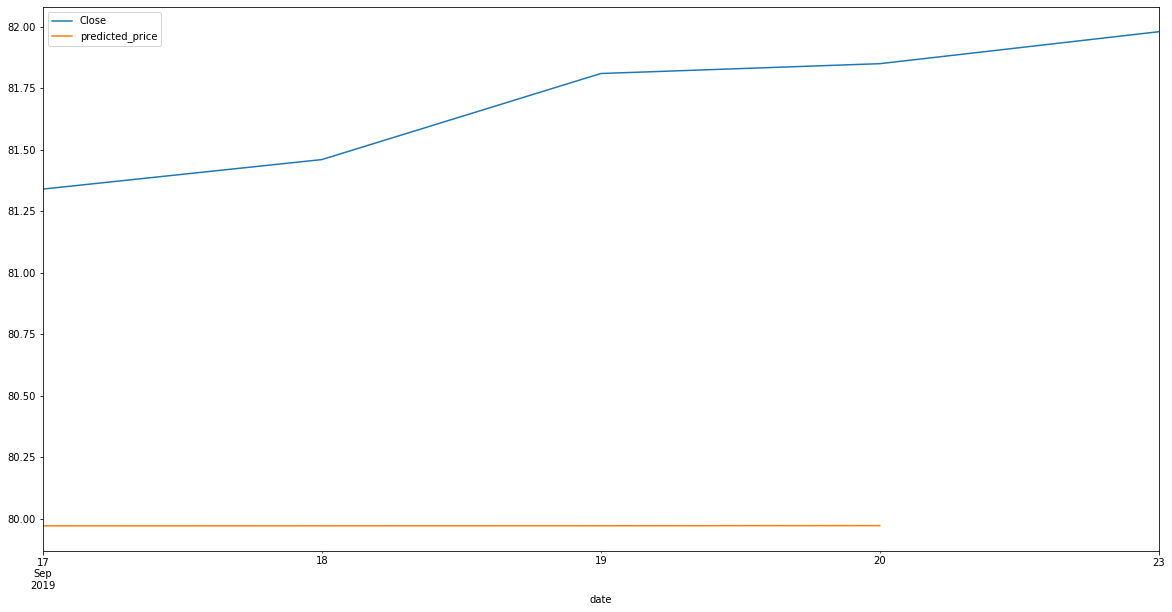

In [8]:

#Get our base model up and Running

if __name__ == '__main__':
    initDeap()
    # population generated
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats.register("std", np.std)
    stats.register("median", np.median)
    # built in algo used with cross over probability = 0.5, mutation probability = 0.2 and number of generation = 5
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, stats=stats, halloffame=hof,
                                       verbose=True)
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    # this gives us the coefficients. Once we get the coefficients , we can use this coefficients,
    # we can use these to calculate the next day's value based on values on the present day
    
    # predict for 5 days, change the number of days to get that many days of prediction
    prediction_series = predict(hof[0],days=5)
    # sorting the prediction series with all entries of same stock together
   
    prediction_series_sorted = sorted(prediction_series, key=lambda tup: tup[0])
    #print(prediction_series)
    print(stocks[0])
    
    filename = download_dir+'/results_predicted-'+stocks[0]+'-.csv'
    #Store our testFileName
    testFileName=download_dir+'/ASX.AX-Test.csv'
    #load our testFileName
    test_file_name= pd.read_csv(testFileName)
    closingPrices=test_file_name['Close']
    print(closingPrices)
    #print("type")
    #print(type(closingPrices))
    closingPrices=closingPrices.values.tolist()
    #print(closingPrices)
    #closingPrices=list(zip(closingPrices))

    
    
    
    
    
    print(filename)
    with open(filename, 'w') as csvfile:
        fieldnames = ['stock',
                      'date','actual_price','predicted_price','price_prev_day','deviation','movement']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        i=1
        #writer.writerow({'stock': stockNames , 'date': '16/09/2019','actual_price': closingPrices[0],'predicted_price': "Actual Price on 16th",'price_prev_day': "NA",'deviation':"NA",'movement':"NA"})
        for prediction in prediction_series_sorted:
            #Classify it as up or down
            movement = 'DOWN' if prediction[4] < 0 else 'UP'
            print("movment: "+movement)
            print("predicted prices")
            print(prediction[1].strftime('%m/%d/%Y')+"- %s" % prediction[2] )
            writer.writerow(
                {'stock': prediction[0], 'date': prediction[1].strftime('%m/%d/%Y'),'predicted_price': prediction[2],'price_prev_day': prediction[3],'deviation':prediction[4],'movement':movement})
            i=i+1
            
    predictedCSV=pd.read_csv(filename,usecols=(1,3),header = 0, index_col = 0,parse_dates=True, infer_datetime_format=True)

#print(testFileName)

    actualCSV=pd.read_csv(testFileName,usecols=(0,4),header = 0, index_col = 0,parse_dates=True, infer_datetime_format=True)

    
    print(actualCSV)

#print(current_data['close'])

#for predictedPrices in prediction_series_sorted
    tryThis = actualCSV.plot(figsize=(20,10))
    predictedCSV.plot(ax=tryThis)
    
    
    
    
